In [109]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
import pandas as pd
import pickle
import numpy as np
from seaborn import heatmap
import os
import matplotlib.pyplot as pl
from pandas.plotting import scatter_matrix
from matplotlib import rcParams
from IPython.core.display import HTML, display

In [2]:
%matplotlib inline
display(HTML("<style>.container{width: 90% !important}</style>"))

In [22]:
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['figure.titlesize'] = 18
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 18

In [4]:
with open('./PklJar/TrainSet.pkl', 'rb') as f:
    trainFrames = pickle.load(f)
    
dfTrainFeatures = trainFrames['features']
dfTrainLabels = trainFrames['labels']

In [65]:
def GetRrsIdx(df, label_list=None):
    if label_list:
        return [df.columns.get_loc(label) for label in label_list]
    else:
        return [df.columns.get_loc(col) for col in df.filter(like='Rrs', axis=1).columns]

In [96]:
class AddBandRatios(BaseEstimator, TransformerMixin):
    """ class to add attributes. """
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.log_transform:
            band_ratio = np.log(X[:, numerator_ix]) / np.log(X[:, denominator_ix])
        else:
            band_ratio = X[:, numerator_ix] / X[:, denominator_ix]
        return np.c_[X, band_ratio]
    
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self
    
    def tranform(self, X, to_log_ix):
        return np.log(X[:, to_log_ix])

In [98]:
rrs443_ix, rrs531_ix, rrs555_ix = GetRrsIdx(dfTrainFeatures, label_list=['Rrs443', 'Rrs531', 'Rrs555'])

In [93]:
dfTrFeats = dfTrainFeatures.copy()

In [100]:
add_band_ratio = RatioGetter()
band_ratio_531_to_443 = add_band_ratio.transform(dfTrFeats.values, rrs531_ix, rrs443_ix)
band_ratio_555_to_443 = add_band_ratio.transform(band_ratio_531_to_443, rrs555_ix, rrs443_ix)

In [101]:
dfTrFeats = pd.DataFrame(band_ratio_555_to_443, index= dfTrainFeatures.index, columns=dfTrainFeatures.columns.tolist() + ['br531_443', 'br555_443'])

In [102]:
dfTrFeats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223 entries, 79 to 102
Data columns (total 9 columns):
SST          223 non-null float64
SSS          223 non-null float64
Rrs412       223 non-null float64
Rrs443       223 non-null float64
Rrs531       223 non-null float64
Rrs555       223 non-null float64
Rrs667       223 non-null float64
br531_443    223 non-null float64
br555_443    223 non-null float64
dtypes: float64(9)
memory usage: 22.4 KB


In [103]:
dfTrainAll = pd.concat((dfTrFeats, dfTrainLabels), axis=1)

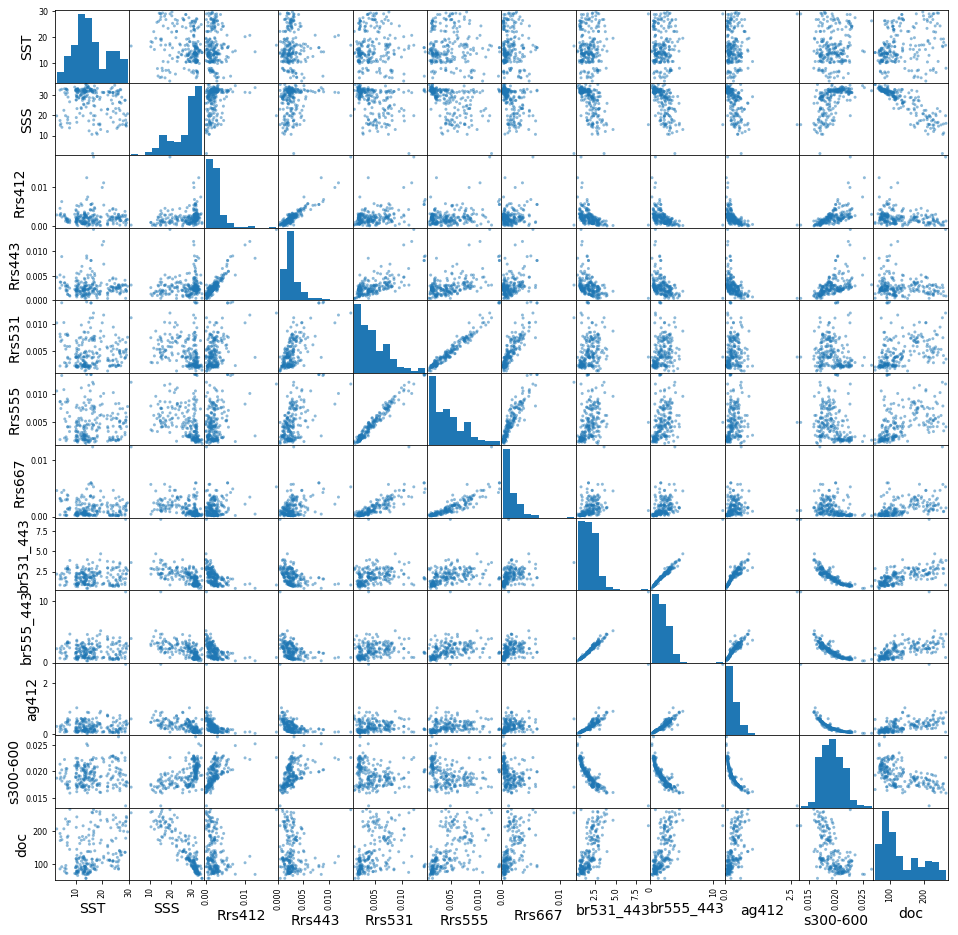

In [106]:
scatter_matrix(dfTrainAll, figsize=(16, 16));

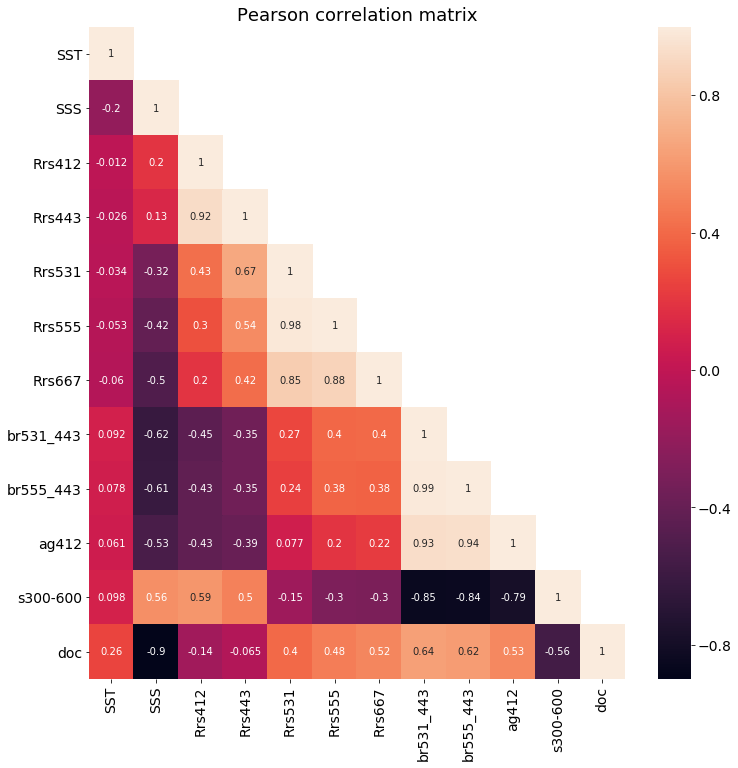

In [108]:
f, ax = pl.subplots(figsize=(12,12))
heatmap(dfTrainAll.corr(), ax=ax, annot=True, mask=np.triu(np.ones((dfTrainAll.shape[1], dfTrainAll.shape[1])), k=1));
ax.set_title('Pearson correlation matrix')
f.savefig('./FigJar/corrMat_br531_443.png')

For ag412 and doc, standardize the data. 
For s300_412, log transform the rrs data, then standardize all features.

To verify this, create three datasets with allfeatures and one of the targets.
Then re-compute correlations

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


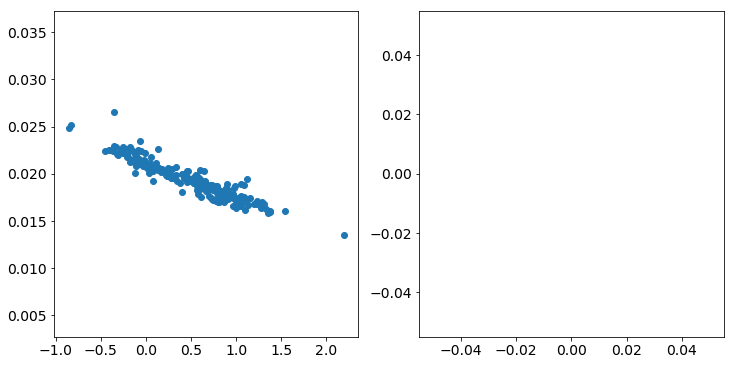

In [113]:
f, ax = pl.subplots(ncols=2, figsize=(12,6))
ax[0].scatter(np.log(dfTrain_S300_600.br531_443), dfTrain_S300_600['s300-600'])
ax[1].scatter(np.log(dfTrain_S300_600.Rrs531) / (np.log(dfTrain_S300_600.Rrs443)), dfTrain_S300_600['s300-600'])

In [111]:
dfTrain_S300_600.head()

,SST,SSS,Rrs412,Rrs443,Rrs531,Rrs555,Rrs667,br531_443,s300-600
79,10.295,31.504,-6.802495,-6.213609,-5.598342,-5.746168,-7.937775,1.850150,0.018833
124,28.110,20.630,-6.991137,-6.351574,-5.387805,-5.338098,-6.326098,2.621560,0.017456
33,23.852,33.562,-6.040400,-5.902880,-6.099048,-6.358334,-8.523808,0.821874,0.021810
86,16.690,27.010,-6.624835,-6.307820,-5.423654,-5.425696,-6.302893,2.420966,0.017837
83,13.027,28.172,-6.230229,-6.157755,-5.569601,-5.580415,-7.140949,1.800661,0.018627


In [70]:
dfTrain_S300_600 = dfTrainAll2.drop(['ag412', 'doc'], axis=1)
dfTrain_doc = dfTrainAll2.drop(['ag412', 's300-600'], axis=1)
dfTrain_ag412 = dfTrainAll2.drop(['s300-600', 'doc'], axis=1)

In [72]:
rrs_ix = GetRrsIdx(dfTrain_S300_600)

In [81]:
lt = LogTransformer(rrs_ix)

In [82]:
X_log = lt.tranform(dfTrain_S300_600.drop('s300-600',axis=1).values)

In [83]:
dfTrain_S300_600.iloc[:, rrs_ix] = X_log

In [88]:
(3*3 + 2*2 + 2*1) / 9

1.6666666666666667